<a href="https://colab.research.google.com/github/ipavlopoulos/palit/blob/main/train_fcnnr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Source code
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
from skimage import transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import *
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import confusion_matrix
import xgboost as xgb 

from tqdm.notebook import tqdm
import os
import random
class FCNNR(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, stride=1, padding=0)
        self.norm1 =  nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.norm2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(41472, 1024, bias=True) # 108928 if the 2nd ConvNet is active
        self.norm3 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512, bias=True)
        self.norm4 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.1)
        self.fc3 = nn.Linear(512, 1, bias=True) # regression output

    def forward(self, x):
        x = self.pool(self.norm1(F.relu(self.conv1(x.unsqueeze(1)))))
        x = self.pool(self.norm2(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.norm3(F.relu(self.fc1(x)))
        x = self.norm4(F.relu(self.fc2(x)))
        #x = self.dropout(x) # our augmentation is competitive to dropout at the input (yet locally coherent)
        x = self.fc3(x)
        return x

# the model predicts the average - high variance
def validate(model, dataloader, device="cpu"):
    predictions, gold_labels = [], []
    with torch.no_grad():
        for id_batch, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            model.eval()
            model.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy()[:, 0])
            gold_labels.extend(labels.cpu())
    return predictions, gold_labels

def train(model, dataloader, optimizer, criterion, val_dataloader=None, patience=3, val_metric = mean_absolute_error, n_print=10, N_EPOCHS=4, device="cpu"):
    losses, mae_losses, val_losses, train_losses = [], [], [], []
    dataset_size = len(dataloader.dataset)
    lowest_error = 100000
    best_epoch = -1
    for epoch in range(N_EPOCHS):
        print(f"Epoch {epoch + 1}\n-------------------------------")

        # Loop over batches in an epoch using DataLoader
        for id_batch, (inputs, labels) in enumerate(dataloader):
            model.train()
            inputs, labels = inputs.to(device), labels.float().flatten().to(device)
            outputs = model(inputs).flatten()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print the loss for this batch (every n batches, plus the # examples)
            if id_batch % n_print == 0:
                loss, current = loss.item(), (id_batch + 1) * len(inputs)
                losses.append(loss)
                mae = nn.L1Loss()
                mae_loss = mae(outputs, labels)
                mae_losses.append(mae_loss)
                print(f"loss: {loss:.2f} (@all: {np.mean(losses):.2f}) mae: {mae_loss:.2f}  [{current:>2d}/{dataset_size:>2d}]")

        if val_dataloader is not None:
            if (patience>0) and (epoch-best_epoch>patience-1):
                print("Max patience reached, now loading the best checkpoint...")
                model.load_state_dict(torch.load("checkpoint.pt"))
                print("Exiting...")
                break
            predictions, labels = validate(model, val_dataloader, device=device)
            val_error = val_metric(predictions, labels)
            train_predictions, train_labels = validate(model, dataloader, device=device)
            train_error = val_metric(train_predictions, train_labels)
            val_losses.append(val_error)
            train_losses.append(train_error)
            if (patience>0) and (val_error<lowest_error):
                lowest_error = val_error
                best_epoch = epoch
                torch.save(model.state_dict(), "checkpoint.pt")
            print(f"Train loss: {train_error:.2f}, Val loss: {val_error:.2f}, Best Epoch: {best_epoch+1} (Val loss: {lowest_error:.2f}) [val var: {np.var(predictions):.2f}, min-max: {min(predictions):.2f}-{max(predictions):.2f}]")
    return losses, mae_losses, train_losses, val_losses

class ImageDataset(TensorDataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        sample, date = self.dataframe.iloc[idx].img.astype(np.float32), self.dataframe.iloc[idx].date
        if self.transform is not None:
            sample = self.transform(sample)
            sample = sample.reshape(sample.shape[1], sample.shape[2]) # grayscale
        return sample, date # 1CE-4CE


augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(3), # turn
    transforms.RandomResizedCrop((50, 300), scale=(0.75, 1.0), ratio=(1, 6)), # crop n scale (add scale to control this)
    #transforms.RandomCrop((30, 30)),
    transforms.GaussianBlur(3), # blur
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, value=0.5), # erase
])

cc_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop((50, 300)),
    transforms.ToTensor(),
])

rs_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((50,300)),
    transforms.ToTensor(),
])

# Data loading

In [2]:
%%capture
!gdown 1kNgqJCFZS4Q-P2YSaeaYp9P2bTobyOCV
pll = pd.read_pickle("pll.csv")

In [3]:
dataset = pll.explode("img")
dataset = dataset[dataset.img.notna()]
print("Lines num:", dataset.shape[0])
w,h = 300,50
img_data = pd.DataFrame(dataset.img.apply(lambda x: x.shape).tolist(), index=dataset.index, columns=["H", "W"])
dataset = dataset[(img_data.W>w)&(img_data.H>h)]
dataset.insert(0, "lid", range(1, dataset.shape[0]+1))

Lines num: 4717


2615 79 80


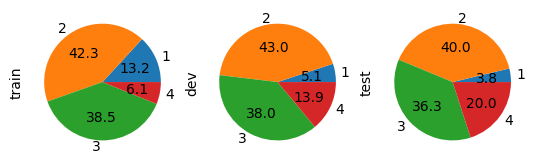

In [4]:
# Data split with non-exclusive fragments between train, val, test
#pll_train, pll_test = train_test_split(dataset, test_size=0.1, random_state=2023)
#pll_train, pll_val = train_test_split(pll_train, test_size=pll_test.shape[0], random_state=2023)

# Train, dev, test lines taken from different fragments
testmod = 13
pll_test = dataset[dataset.uid%testmod==0]
pll_test, pll_val = train_test_split(pll_test, test_size=pll_test.shape[0]//2, random_state=2021)
pll_train = dataset[dataset.uid%testmod!=0]

print(pll_train.shape[0], pll_val.shape[0], pll_test.shape[0])
pd.DataFrame({"train": pll_train.date.value_counts(),                
              "dev": pll_val.date.value_counts(),
              "test":pll_test.date.value_counts()}).plot.pie(subplots=True, autopct=f'%.1f', legend=False);


# Training

Epoch 1
-------------------------------
loss: 1.91 (@all: 1.91) mae: 2.41  [32/2615]
loss: 1.69 (@all: 1.80) mae: 2.17  [352/2615]
loss: 1.43 (@all: 1.68) mae: 1.93  [672/2615]
loss: 1.44 (@all: 1.62) mae: 1.92  [992/2615]
loss: 1.39 (@all: 1.57) mae: 1.85  [1312/2615]
loss: 1.21 (@all: 1.51) mae: 1.71  [1632/2615]
loss: 0.63 (@all: 1.39) mae: 1.07  [1952/2615]
loss: 0.53 (@all: 1.28) mae: 0.93  [2272/2615]
loss: 0.27 (@all: 1.17) mae: 0.62  [2592/2615]
Train loss: 4.75, Val loss: 4.40, Best Epoch: 1 (Val loss: 4.40) [val var: 0.00, min-max: 4.42-4.64]
Epoch 2
-------------------------------
loss: 0.45 (@all: 1.10) mae: 0.87  [32/2615]
loss: 0.24 (@all: 1.02) mae: 0.58  [352/2615]
loss: 0.36 (@all: 0.96) mae: 0.73  [672/2615]
loss: 0.34 (@all: 0.92) mae: 0.73  [992/2615]
loss: 0.27 (@all: 0.87) mae: 0.65  [1312/2615]
loss: 0.24 (@all: 0.83) mae: 0.62  [1632/2615]
loss: 0.20 (@all: 0.79) mae: 0.57  [1952/2615]
loss: 0.31 (@all: 0.76) mae: 0.71  [2272/2615]
loss: 0.32 (@all: 0.74) mae: 0

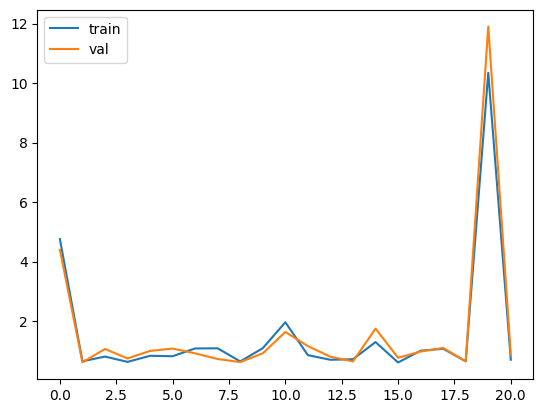

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
fcnn = FCNNR().to(device)
mse_loss, mae_loss, train_losses, val_losses = train(fcnn,
                                                     DataLoader(ImageDataset(pll_train, transform=augment), batch_size=32, shuffle=True, drop_last=False),
                                                     optimizer=optim.Adam(fcnn.parameters(), lr=1e-3, weight_decay=1e-5),
                                                     criterion=nn.SmoothL1Loss(),
                                                     N_EPOCHS=200,
                                                     device=device,
                                                     val_metric=mean_squared_error,
                                                     patience=20,
                                                     val_dataloader=DataLoader(ImageDataset(pll_val, transform=rs_transform), batch_size=32, drop_last=False)
                                                     )

torch.save(fcnn.state_dict(), "checkpoint.pt")
print(f"Parameters: {nn.utils.parameters_to_vector(fcnn.parameters()).numel():.1f}")
fcnn.eval()
pd.DataFrame({"train": train_losses, "val": [float(v) for v in val_losses]}, index=range(len(train_losses))).plot();

# Evaluation

Test loss 0.7119786
Predictions from: 2.58 to 2.66, Var: 0.00
MAE: 0.711979
MSE: 0.679779
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.40      1.00      0.57        32
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00        16

    accuracy                           0.40        80
   macro avg       0.10      0.25      0.14        80
weighted avg       0.16      0.40      0.23        80



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


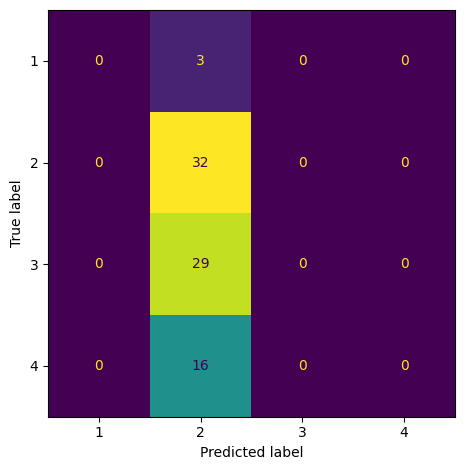

In [6]:
predictions, labels = validate(fcnn, DataLoader(ImageDataset(pll_test, transform=rs_transform), batch_size=1), device="cpu")
print("Test loss", nn.L1Loss()(torch.Tensor(predictions), torch.Tensor(labels)).numpy())
pll_test["cnn"] = predictions
print(f"Predictions from: {pll_test.cnn.min():.2f} to {pll_test.cnn.max():.2f}, Var: {pll_test.cnn.var():.2f}")
print(f"MAE: {mean_absolute_error(labels, predictions):g}")
print(f"MSE: {mean_squared_error(labels, predictions):g}")

gold_lbls = [int(l.numpy()) for l in labels]
pred_lbls = [int(p) for p in predictions]
print(classification_report(gold_lbls, pred_lbls))
ax = ConfusionMatrixDisplay.from_predictions(gold_lbls, pred_lbls, colorbar=False);
plt.tight_layout(); ax.figure_.savefig('confusion_fcnnr.pdf', format='PDF', dpi=300)